In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!7z e drive/MyDrive/train-jpg.tar.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 629296207 bytes (601 MiB)

Extracting archive: drive/MyDrive/train-jpg.tar.7z
--
Path = drive/MyDrive/train-jpg.tar.7z
Type = 7z
Physical Size = 629296207
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - train-jpg.tar                      1% - train-jpg.tar                      2% - train-jpg.tar                      3% - train-jpg.tar                      4% - train-jpg.tar                      5% - train-jpg.tar                      6% - train-jpg

In [ ]:
!tar -xvf train-jpg.tar

In [4]:
!unzip drive/MyDrive/train_v2.csv.zip

Archive:  drive/MyDrive/train_v2.csv.zip
  inflating: train_v2.csv            
   creating: __MACOSX/
  inflating: __MACOSX/._train_v2.csv  


In [5]:
from os import listdir
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Plotting

In [6]:
documenttitle = 'train_v2.csv'
csv_df_map = pd.read_csv(documenttitle)

In [7]:
csv_df_map

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


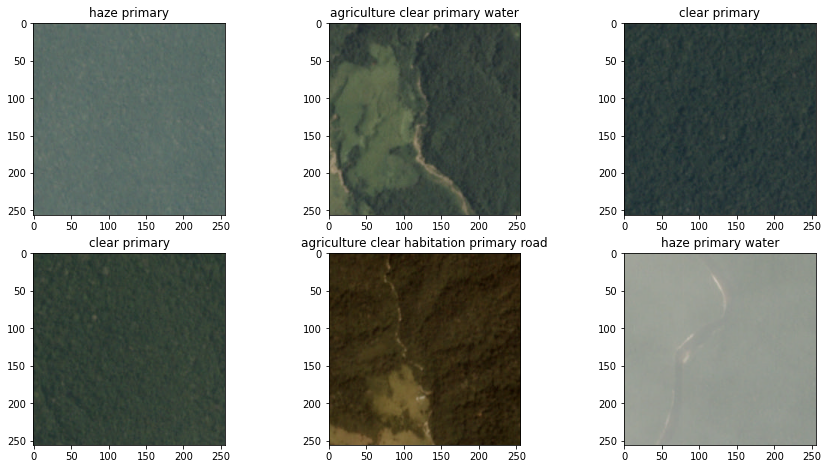

In [13]:
folder = 'train-jpg/'
plt.figure(figsize=(15, 12))
for i in range(6):
    plt.subplot(331 + i)
    filename = folder + 'train_' + str(i) + '.jpg'
    tags = csv_df_map['tags'][i]
    image = plt.imread(filename)
    plt.imshow(image)
    plt.title(tags)
plt.show()

In [15]:
all_tags = []
for i in range(len(csv_df_map)):
    tags = csv_df_map['tags'][i].split(' ')
    all_tags += tags

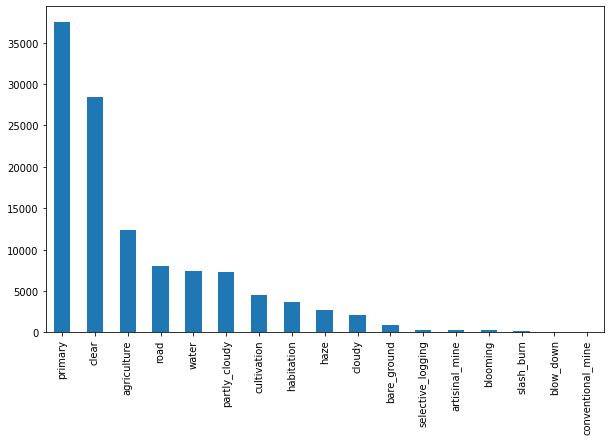

In [20]:
plt.figure(figsize=(10, 6))
df = pd.DataFrame(all_tags, columns=['all_tags'])
df['all_tags'].value_counts().plot(kind='bar')
plt.show()

## Save images as numpy files

Once npz file is made, no need to run this piece of code

In [ ]:
def load_from_np_file(path, document_dictionary, tag_dictionary):
		pics, dep_vars = list(), list()
		for documenttitle in listdir(folder):
			pic = load_img(path + documenttitle, target_size=(64,64))
			pic = img_to_array(pic, dtype='uint8')
			tags = document_dictionary[documenttitle[:-4]]
			dep_var = encode_1Hot(tags, tag_dictionary)
			pics.append(pic)
			dep_vars.append(dep_var)
		X = np.asarray(pics, dtype='uint8')
		y = np.asarray(dep_vars, dtype='uint8')
		return X, y

def map_labels(csv_df_map):
		map_tags = set()
		for i in range(len(csv_df_map)):
			tags = csv_df_map['tags'][i].split(' ')
			map_tags.update(tags)
		map_tags = list(map_tags)
		map_tags.sort()
		map_tags_map = {map_tags[i]:i for i in range(len(map_tags))}
		inv_map_tags_map = {i:map_tags[i] for i in range(len(map_tags))}
		return map_tags_map, inv_map_tags_map
 
def develop_document_dictionary(csv_df_map):
		dictionary = dict()
		for i in range(len(csv_df_map)):
			title, tags = csv_df_map['image_name'][i], csv_df_map['tags'][i]
			dictionary[title] = tags.split(' ')
		return dictionary
 
def encode_1Hot(tags, dictionary):
		encrypt = np.zeros(len(dictionary), dtype='uint8')
		for tag in tags:
			encrypt[dictionary[tag]] = 1
		return encrypt

documenttitle = 'train_v2.csv'
csv_df_map = pd.read_csv(documenttitle)
tag_dictionary, _ = map_labels(csv_df_map)
document_dictionary = develop_document_dictionary(csv_df_map)
folder = 'train-jpg/'
X, y = load_from_np_file(folder, document_dictionary, tag_dictionary)

np.savez_compressed('drive/MyDrive/amazon_rainforest_data.npz', X, y)

(40479, 64, 64, 3) (40479, 17)


In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as rear
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD
 
def load_from_np_file():
		df = np.load('drive/MyDrive/amazon_rainforest_data.npz')
		X, y = df['arr_0'], df['arr_1']
		X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
		print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
		return X_train, y_train, X_test, y_test
 
def beta_F(y_true, y_pred, beta=2):
		y_pred = rear.clip(y_pred, 0, 1)
		true_positive = rear.sum(rear.round(rear.clip(y_true * y_pred, 0, 1)), axis=1)
		false_positive = rear.sum(rear.round(rear.clip(y_pred - y_true, 0, 1)), axis=1)
		false_negative = rear.sum(rear.round(rear.clip(y_true - y_pred, 0, 1)), axis=1)
		p = true_positive / (true_positive + false_positive + rear.epsilon())
		r = true_positive / (true_positive + false_negative + rear.epsilon())
		beta_square = beta ** 2
		beta_F_score = rear.mean((1 + beta_square) * (p * r) / (beta_square * p + r + rear.epsilon()))
		return beta_F_score
 
def define_cnn_classifier(initial_size=(64, 64, 3), final_size=17):
		cnn_classifier = Sequential()
		cnn_classifier.add(Conv2D(32, (3, 3), activation='relu', 
		                          kernel_initializer='he_uniform', 
															padding='same', input_shape=initial_size))
		cnn_classifier.add(Conv2D(32, (3, 3), activation='relu', 
		                          kernel_initializer='he_uniform', 
															padding='same'))
		cnn_classifier.add(MaxPooling2D((2, 2)))
		cnn_classifier.add(Conv2D(64, (3, 3), activation='relu', 
		                          kernel_initializer='he_uniform', 
															padding='same'))
		cnn_classifier.add(Conv2D(64, (3, 3), activation='relu', 
		                          kernel_initializer='he_uniform', 
															padding='same'))
		cnn_classifier.add(MaxPooling2D((2, 2)))
		cnn_classifier.add(Flatten())
		cnn_classifier.add(Dense(128, activation='relu', 
		                         kernel_initializer='he_uniform'))
		cnn_classifier.add(Dense(final_size, activation='sigmoid'))
		opt = SGD(learning_rate=0.01, momentum=0.9)
		cnn_classifier.compile(optimizer=opt, loss='binary_crossentropy', 
		                       metrics=[beta_F])
		return cnn_classifier
 
X_train, y_train, X_test, y_test = load_from_np_file()
train_dfgen = IDG(rescale=1.0/255.0, 
                                 horizontal_flip=True, 
                                 vertical_flip=True, 
																 rotation_range=90)
test_dfgen = IDG(rescale=1.0/255.0)
train_batch = train_dfgen.flow(X_train, y_train, batch_size=128)
test_batch = test_dfgen.flow(X_test, y_test, batch_size=128)
cnn_classifier = define_cnn_classifier()
hist = cnn_classifier.fit(train_batch, steps_per_epoch=len(train_batch),
                          validation_data=test_batch, 
													validation_steps=len(test_batch), 
													epochs=80, verbose=1)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)
Epoch 1/80
253/253 [==============================] - 56s 164ms/step - loss: 0.2419 - beta_F: 0.6539 - val_loss: 0.2155 - val_beta_F: 0.6818
Epoch 2/80
253/253 [==============================] - 42s 165ms/step - loss: 0.2081 - beta_F: 0.6891 - val_loss: 0.2070 - val_beta_F: 0.6987
Epoch 3/80
253/253 [==============================] - 41s 163ms/step - loss: 0.2017 - beta_F: 0.7047 - val_loss: 0.2036 - val_beta_F: 0.7160
Epoch 4/80
253/253 [==============================] - 42s 165ms/step - loss: 0.1958 - beta_F: 0.7243 - val_loss: 0.1970 - val_beta_F: 0.7238
Epoch 5/80
253/253 [==============================] - 39s 153ms/step - loss: 0.1918 - beta_F: 0.7334 - val_loss: 0.1931 - val_beta_F: 0.7225
Epoch 6/80
253/253 [==============================] - 39s 153ms/step - loss: 0.1876 - beta_F: 0.7415 - val_loss: 0.1879 - val_beta_F: 0.7545
Epoch 7/80
253/253 [==============================] - 40s 157ms/step - loss: 0.1864 - beta_F: 

> loss=0.136, fbeta=0.840


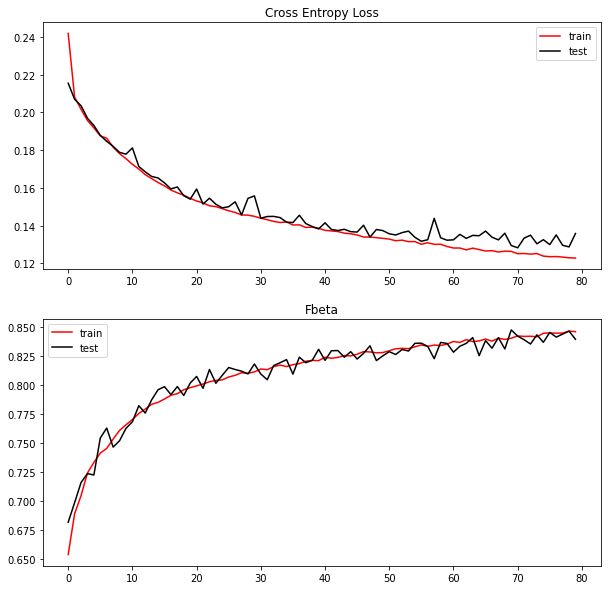

In [ ]:
def plotting_loss_and_accuracy(hist):
    plt.figure(figsize=(10,10))
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(hist.history['loss'], color='red', label='train')
    plt.plot(hist.history['val_loss'], color='black', label='test')
    plt.legend()

    plt.subplot(212)
    plt.title('Fbeta')
    plt.plot(hist.history['beta_F'], color='red', label='train')
    plt.plot(hist.history['val_beta_F'], color='black', label='test')

    plt.legend()
    plt.show()

loss, beta_F_sc = cnn_classifier.evaluate(test_batch, steps=len(test_batch), verbose=0)
print('> loss=%.3f, fbeta=%.3f' % (loss, beta_F_sc))
plotting_loss_and_accuracy(hist)